In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
import numpy as np
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline
import pygmo as pg
from pygmo import algorithm
import os
import sys
import json
from orbsim.constants import *
from orbsim.analyticals import *
from orbsim.simulators import launch_sim
import time
from random import shuffle

In [2]:
import inspect
import math

In [7]:
class saddle_space:
    def __init__(self):
        self.dim = 2
    
    def fitness(self,psi):
        print(psi)
        res,_ = launch_sim(psi,max_iter=100000)
        print(res)
        return [res]
    
    def get_bounds(self):
        return ([-pi,-pi,-4],[pi,pi,4])
    
    def get_name(self):
        return f"saddlespace"
    
    def plot(self, w, idx):
        plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
        x,y = zip(*w)
        plt.scatter(x,y,4,'k',edgecolors='face')
        plt.scatter(w[idx][0],w[idx][1],15,'y',edgecolors='k')

In [8]:
class salimans_nes:
    def __init__(self,iter=12):
        super(salimans_nes,self).__init__()
        self.prevx,self.prevy = [],[]
        
        self.iter=iter # number of steps towards estimated gradient
    
    def evolve(self,pop):
        if len(pop) == 0:
            return pop
        sigma = 3
        alpha = 0.03 # learningrate
        
        # plotting
        plotting = False
        if plotting:
            plt.figure(figsize=(self.iter,self.iter))
            no_rows = int(self.iter/4+1)
            gs = gridspec.GridSpec(no_rows,4)
            plot_index = 0
        
        #for each iteration, jitter around starting points, and move in the
        #best direction (weighted average jitter coordinates according to 
        #fitness score)
        for i in range(self.iter):
            
            if plotting:
                ax1=plt.subplot(gs[int(i/4),plot_index])
                plot_index += 1
                if plot_index == 4:
                    plot_index = 0
                plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
            
            #get the population    
            wl = pop.get_x()
            
            #do the jittering and selection
            j=0
            for w in wl:
                noise = np.random.randn(200,2)
                wp = [[min(99,max(0,x)),min(99,max(0,y))] for [x,y] in np.expand_dims(w, 0) + sigma*noise]
                
                
                
                if plotting:
                    x,y = zip(*wp)
                    plt.scatter(x,y,4,'k',edgecolors='face')
                R = np.array([prob.fitness(wi)[0] for wi in wp])
                R -= R.mean()
                R /= R.std()
                g = np.dot(R, noise)
                u = alpha * g
                w += u # mutate the population
                w = [min(99,max(0,w[0])),min(99,max(0,w[1]))] # bounds
                pop.set_x(j,w)# make the move previously selected
                j+=1
        return pop

    def get_name(self):
        return f"Oisin's big-dick omegafantastic algorithm"

In [9]:
def pygmo_es():
    uda = salimans_nes(iter=25)  # user defined algorithm
    udp = saddle_space()  # user defined problem
    prob = pg.problem(udp) # Beautiful white snow

    archi = pg.archipelago(algo=uda, prob=udp, n=50, pop_size=30)
    archi.evolve()
    sols = archi.get_champions_f()
    idx = sols.index(min(sols))
    #print("Done!! Solutions found are: ")
    #print(archi.get_champions_f())
    udp.plot(archi.get_champions_x(),idx)

    #pop = pg.population(prob,10,3)
    #algo.evolve(pop)

[ 2.13286875 -1.34828379 -0.12915095]
0.0048051508844953175
smallest distance = 0.9834998860468142

symplectic runtime: 8.706996440887451
10000000000.0
[ 1.25052976  2.98168478 -1.11823318]
0.0048051508844953175
smallest distance = 0.9883803465392655

symplectic runtime: 16.715004444122314
10000000000.0
[ 1.94553181  0.69215896 -2.85121554]
0.0048051508844953175
smallest distance = 0.9937239176259204

symplectic runtime: 15.969997644424438
10000000000.0
[1.35614616 1.27324107 3.05116329]
0.0048051508844953175
smallest distance = 0.9889102622849246

symplectic runtime: 8.920005321502686
10000000000.0
[1.3141269  2.68967371 3.57706704]
0.0048051508844953175
smallest distance = 0.9958252991919481

symplectic runtime: 8.079989910125732
10000000000.0
[ 1.2537211  -0.78375173 -2.1776644 ]
0.0048051508844953175
smallest distance = 0.9948369760315734

symplectic runtime: 8.505003690719604
10000000000.0
[-1.98057478  1.2386124  -0.88402366]
0.0048051508844953175
smallest distance = 0.9833818957

smallest distance = 0.9864043815067624

symplectic runtime: 7.8610053062438965
10000000000.0
[-1.9888679   0.90669095 -0.95459386]
0.0048051508844953175
smallest distance = 0.9811049122111264

symplectic runtime: 8.00899338722229
10000000000.0
[ 1.62284675 -1.90146852 -2.82355792]
0.0048051508844953175
smallest distance = 1.0010277546336521

symplectic runtime: 7.801990270614624
10000000000.0
[-1.9381085  -1.43531984 -3.19150366]
0.0048051508844953175
smallest distance = 0.9382369414134393

symplectic runtime: 7.805006742477417
10000000000.0
[2.64051513 0.04789691 1.31359156]
0.0048051508844953175
smallest distance = 0.970613486487326

symplectic runtime: 8.01597547531128
10000000000.0
[-2.58296336 -3.08485882 -1.64013615]
0.0048051508844953175
smallest distance = 0.9910799664636405

symplectic runtime: 7.814006090164185
10000000000.0
[-3.08275494  1.0293171   2.07647427]
0.0048051508844953175
smallest distance = 0.9931683173021268

symplectic runtime: 7.9179887771606445
10000000000.0


smallest distance = 0.9848111700048156

symplectic runtime: 9.487000226974487
10000000000.0
[ 2.90366799 -0.32166282  3.54198478]
0.0048051508844953175
smallest distance = 0.8586202002343213

symplectic runtime: 12.661065816879272
10000000000.0
[-0.4121611   1.83680025 -0.30331093]
0.0048051508844953175
smallest distance = 0.9830557913068907

symplectic runtime: 9.677996158599854
10000000000.0
[ 2.38033628 -2.23037532 -2.59527832]
0.0048051508844953175
smallest distance = 0.9691620965884613

symplectic runtime: 8.223008155822754
10000000000.0
[-3.11185229  1.10664395 -3.79131764]
0.0048051508844953175
smallest distance = 0.5125257551922452

symplectic runtime: 10.289000034332275
10000000000.0
[-2.35756341 -0.50066473  2.01666223]
0.0048051508844953175
smallest distance = 0.9912307698935295

symplectic runtime: 8.754012107849121
10000000000.0
[-3.13042913  1.65115347  0.0506691 ]
0.0048051508844953175
smallest distance = 0.9832242447184385

symplectic runtime: 8.372004508972168
10000000

smallest distance = 0.9835350602916675

symplectic runtime: 10.509007215499878
10000000000.0
[-2.77623432 -2.58560827 -0.18380209]
0.0048051508844953175
smallest distance = 0.9842100479083378

symplectic runtime: 8.943973541259766
10000000000.0
[-2.81722254 -2.95448537 -2.31023957]
0.0048051508844953175
smallest distance = 0.9919903835910822

symplectic runtime: 10.033002138137817
10000000000.0
[-1.13399518  0.42683573  3.93379103]
0.0048051508844953175
smallest distance = 0.9565177447632542

symplectic runtime: 10.512138843536377
10000000000.0
[-2.15781634  3.0246136  -1.94082056]
0.0048051508844953175
smallest distance = 0.9920295915174222

symplectic runtime: 9.601131677627563
10000000000.0
[ 2.88152186 -1.19597829  3.37061958]
0.0048051508844953175
smallest distance = 0.7579343897726664

symplectic runtime: 9.009000062942505
10000000000.0
[-0.09901906  0.75974062  0.29999158]
0.0048051508844953175
smallest distance = 0.9829575204004536

symplectic runtime: 9.645036697387695
1000000

smallest distance = 0.9919114982946579

symplectic runtime: 8.815999507904053
10000000000.0
[ 1.75346243  2.20642496 -0.72541467]
0.0048051508844953175
smallest distance = 0.9854456993309079

symplectic runtime: 8.667001485824585
10000000000.0
[ 2.63817105 -2.42297916 -1.21829523]
0.0048051508844953175
smallest distance = 0.9808168601906029

symplectic runtime: 8.60201621055603
10000000000.0
[ 1.84214397 -1.12099453  1.95049142]
0.0048051508844953175
smallest distance = 0.9868710181456251

symplectic runtime: 8.865983009338379
10000000000.0
[-0.07428789  2.91214184  1.48143429]
0.0048051508844953175
smallest distance = 0.9830668030771575

symplectic runtime: 8.655003070831299
10000000000.0
[ 0.47845677  3.05678441 -1.03683612]
0.0048051508844953175
smallest distance = 0.9849571674544526

symplectic runtime: 8.592008113861084
10000000000.0
[ 2.12296564 -0.47664476 -1.40445659]
0.0048051508844953175
smallest distance = 0.9892920809708287

symplectic runtime: 8.685997486114502
10000000000

smallest distance = 0.9560539818806458

symplectic runtime: 8.795998573303223
10000000000.0
[-2.79406171  0.03547089  3.90153736]
0.0048051508844953175
smallest distance = 0.9944828745059349

symplectic runtime: 8.622004747390747
10000000000.0
[-3.11281711  2.04527426  0.17263024]
0.0048051508844953175
smallest distance = 0.9840631151263627

symplectic runtime: 8.671024560928345
10000000000.0
[-1.94998387 -1.42702351  3.13629637]
0.0048051508844953175
smallest distance = 0.9914138053187376

symplectic runtime: 8.751997470855713
10000000000.0
[-0.66718898 -1.43896474  3.31481636]
0.0048051508844953175
smallest distance = 0.9852662695566218

symplectic runtime: 8.723004341125488
10000000000.0
[ 3.09250322 -1.11664687  3.26803803]
0.0048051508844953175
smallest distance = 0.7356778146746439

symplectic runtime: 8.609999895095825
10000000000.0
[ 0.33538807  0.60091324 -0.7327496 ]
0.0048051508844953175
smallest distance = 0.9839813231710058

symplectic runtime: 9.129998922348022
1000000000

smallest distance = 0.9907098951144908

symplectic runtime: 8.733973503112793
10000000000.0
[ 1.1086123  -0.73675886 -3.95058494]
0.0048051508844953175
smallest distance = 0.9925452081577496

symplectic runtime: 8.573999166488647
10000000000.0
[ 1.58181489 -0.43770531 -3.01957093]
0.0048051508844953175
smallest distance = 0.9975627121153946

symplectic runtime: 8.666025161743164
10000000000.0
[ 1.57395619 -2.78753762  1.12380023]
0.0048051508844953175
smallest distance = 0.9891789041991546

symplectic runtime: 8.77899980545044
10000000000.0
[-1.38898979 -2.52909315 -3.9288295 ]
0.0048051508844953175
smallest distance = 0.964268954977844

symplectic runtime: 8.651007175445557
10000000000.0
[-0.36839957  1.0232227   3.34231519]
0.0048051508844953175
smallest distance = 0.9788266341661169

symplectic runtime: 8.63313913345337
10000000000.0
[-1.76804472  1.2002712   3.95042976]
0.0048051508844953175
smallest distance = 0.948571925440872

symplectic runtime: 8.99000072479248
10000000000.0
[

smallest distance = 0.9838473595552352

symplectic runtime: 8.763006448745728
10000000000.0
[2.58127736 0.84474238 2.90948234]
0.0048051508844953175
smallest distance = 0.9774622136071577

symplectic runtime: 10.118010520935059
10000000000.0
[-0.51865652  2.50735553  2.40237354]
0.0048051508844953175
smallest distance = 0.983994106664757

symplectic runtime: 8.905021905899048
10000000000.0
[-2.53741113  2.93435219  1.10077198]
0.0048051508844953175
smallest distance = 0.9732941403482108

symplectic runtime: 9.064983606338501
10000000000.0
[-0.71364455  1.36217194 -1.91800238]
0.0048051508844953175
smallest distance = 0.9852572188071592

symplectic runtime: 8.795003652572632
10000000000.0
[1.26449119 1.85286244 1.40119122]
0.0048051508844953175
smallest distance = 0.9877000148479033

symplectic runtime: 9.472999334335327
10000000000.0
[-1.3175848   2.88514409  0.74465889]
0.0048051508844953175
smallest distance = 0.9819014785551069

symplectic runtime: 8.799998760223389
10000000000.0
[ 

smallest distance = 0.9821095180215923

symplectic runtime: 8.619016170501709
10000000000.0
[-1.02786848  1.31521571 -3.2417647 ]
0.0048051508844953175
smallest distance = 0.9889572297431167

symplectic runtime: 8.71397352218628
10000000000.0
[0.17646611 2.08086073 2.30889165]
0.0048051508844953175
smallest distance = 0.9832874505713278

symplectic runtime: 8.606997728347778
10000000000.0
[ 0.14958292  0.14217988 -2.00649314]
0.0048051508844953175
smallest distance = 0.983212107284183

symplectic runtime: 8.70099925994873
10000000000.0
[-0.57604882  1.8962533   3.05431917]
0.0048051508844953175
smallest distance = 0.98145742299419

symplectic runtime: 8.81998085975647
10000000000.0
[ 0.46520905 -2.70182898 -1.03737225]
0.0048051508844953175
smallest distance = 0.9848533673213042

symplectic runtime: 8.651588916778564
10000000000.0
[ 1.42096577 -3.04418647 -0.86041426]
0.0048051508844953175
smallest distance = 0.9855035914361711

symplectic runtime: 8.6329984664917
10000000000.0
[-3.079

smallest distance = 0.9838288350605258

symplectic runtime: 8.681998491287231
10000000000.0
[-2.41553712  1.69678021 -1.23316654]
0.0048051508844953175
smallest distance = 0.9806699108589877

symplectic runtime: 8.725999355316162
10000000000.0
[-1.04344465 -2.832726    3.33110598]
0.0048051508844953175
smallest distance = 0.9876156525805281

symplectic runtime: 8.645002603530884
10000000000.0
[-1.38382381  3.04974787 -3.09780484]
0.0048051508844953175
smallest distance = 0.9855028007216798

symplectic runtime: 8.62700343132019
10000000000.0
[-0.13306309  0.05726345  3.65274754]
0.0048051508844953175
smallest distance = 0.9791359165840884

symplectic runtime: 8.810002326965332
10000000000.0
[-1.28652692  1.31174427  3.97000585]
0.0048051508844953175
smallest distance = 0.7059430026137083

symplectic runtime: 8.796994924545288
10000000000.0
[ 1.93267192 -0.53778101  2.18587434]
0.0048051508844953175
smallest distance = 0.9738262802588578

symplectic runtime: 8.626022815704346
10000000000

smallest distance = 0.9787648430677373

symplectic runtime: 8.67799425125122
10000000000.0
[0.95658429 0.16596664 0.04758291]
0.0048051508844953175
smallest distance = 0.9903113048850727

symplectic runtime: 8.796002864837646
10000000000.0
[-1.30197302  2.30215764 -3.46580048]
0.0048051508844953175
smallest distance = 0.989679321237005

symplectic runtime: 8.712000370025635
10000000000.0
[2.39897356 0.35659544 2.14193948]
0.0048051508844953175
smallest distance = 0.9521434950045199

symplectic runtime: 8.760990381240845
10000000000.0
[-1.27061326 -1.41364809 -2.34876555]
0.0048051508844953175
smallest distance = 0.9650410918092298

symplectic runtime: 8.9869966506958
10000000000.0
[1.82397524 2.74064683 1.08930638]
0.0048051508844953175
smallest distance = 0.987164473097682

symplectic runtime: 9.21899938583374
10000000000.0
[-1.21904601 -1.90117583 -0.54605676]
0.0048051508844953175
smallest distance = 0.9807974687972268

symplectic runtime: 8.768000364303589
10000000000.0
[-1.5224250

smallest distance = 0.9928537453465122

symplectic runtime: 7.85799503326416
10000000000.0
[ 1.10481478 -0.9501927   1.45031077]
0.0048051508844953175
smallest distance = 0.9918728396167737

symplectic runtime: 8.006988525390625
10000000000.0
[-2.00279418 -0.12941092  2.38030055]
0.0048051508844953175
smallest distance = 0.9924568300912504

symplectic runtime: 8.025018453598022
10000000000.0
[-0.21971791 -0.44390393  0.22231072]
0.0048051508844953175
smallest distance = 0.9829239640754021

symplectic runtime: 7.9159979820251465
10000000000.0
[ 2.84606952 -0.61058888 -2.52396534]
0.0048051508844953175
smallest distance = 0.9943156227805289

symplectic runtime: 8.154988765716553
10000000000.0
[-1.11608143  1.63471037  3.40798342]
0.0048051508844953175
smallest distance = 0.9500804782608299

symplectic runtime: 7.95999550819397
10000000000.0
[ 0.9114351  -2.4072186   2.51328083]
0.0048051508844953175
smallest distance = 0.9896886974655656

symplectic runtime: 7.830996036529541
10000000000

smallest distance = 0.9953993099260432

symplectic runtime: 7.7590086460113525
10000000000.0
[-2.25956872  2.25492757  3.00356586]
0.0048051508844953175
smallest distance = 0.9379070473399681

symplectic runtime: 7.688978672027588
10000000000.0
[-1.90285127 -1.9511934  -1.12906053]
0.0048051508844953175
smallest distance = 0.9813390692930098

symplectic runtime: 7.747996807098389
10000000000.0
[-0.3023087  -2.68131932  2.8867053 ]
0.0048051508844953175
smallest distance = 0.9838021952537573

symplectic runtime: 7.8869969844818115
10000000000.0
[ 0.77765362 -2.90375418  1.6508166 ]
0.0048051508844953175
smallest distance = 0.9879723169120512

symplectic runtime: 7.750020265579224
10000000000.0
[ 2.81945719  1.77954276 -3.39062548]
0.0048051508844953175
smallest distance = 0.6280570171235796

symplectic runtime: 7.736998558044434
10000000000.0
[ 0.75119423 -2.83335373  2.89647106]
0.0048051508844953175
smallest distance = 0.9876575435148013

symplectic runtime: 7.688002586364746
10000000

smallest distance = 0.9830199467104153

symplectic runtime: 7.7859954833984375
10000000000.0
[-2.59024073 -0.03545322  1.2615869 ]
0.0048051508844953175
smallest distance = 0.9892964530002168

symplectic runtime: 7.929995536804199
10000000000.0
[-2.41172246  0.58931732 -0.6440104 ]
0.0048051508844953175
smallest distance = 0.9766791613245108

symplectic runtime: 8.076995611190796
10000000000.0
[-1.97750849 -0.048914   -0.57411498]
0.0048051508844953175
smallest distance = 0.9787226946833487

symplectic runtime: 7.709996700286865
10000000000.0
[-2.67783345  2.87281951 -0.41927866]
0.0048051508844953175
smallest distance = 0.9845282309097029

symplectic runtime: 7.778994083404541
10000000000.0
[ 0.34874438 -1.17609194  2.09145895]
0.0048051508844953175
smallest distance = 0.9840585260040854

symplectic runtime: 7.720996856689453
10000000000.0
[ 0.33464685 -1.8773634  -2.02495613]
0.0048051508844953175
smallest distance = 0.9839770926887457

symplectic runtime: 7.692018747329712
100000000

smallest distance = 0.9877160127308594

symplectic runtime: 8.282017230987549
10000000000.0
[-1.13354594  1.22906027 -1.47737088]
0.0048051508844953175
smallest distance = 0.9867995736211954

symplectic runtime: 7.910101413726807
10000000000.0
[ 1.12134434 -2.48689393 -1.49512327]
0.0048051508844953175
smallest distance = 0.987134386023428

symplectic runtime: 7.93700385093689
10000000000.0
[-0.37939411  2.76922327 -0.50264083]
0.0048051508844953175
smallest distance = 0.9826627723147563

symplectic runtime: 8.046014547348022
10000000000.0
[-1.45787184 -2.13441805 -3.95058466]
0.0048051508844953175
smallest distance = 0.8657088652148693

symplectic runtime: 7.935996055603027
10000000000.0
[ 2.83282866  1.5353622  -2.38076786]
0.0048051508844953175
smallest distance = 0.9311834428496409

symplectic runtime: 7.880019426345825
10000000000.0
[-0.26366218  2.4467348  -1.34652283]
0.0048051508844953175
smallest distance = 0.9824483263846523

symplectic runtime: 7.869013786315918
10000000000.

smallest distance = 0.9835849863286653

symplectic runtime: 8.153021335601807
10000000000.0
[-1.73650109  2.29769478  3.79455834]
0.0048051508844953175
smallest distance = 0.30277461475671996

symplectic runtime: 8.147995233535767
10000000000.0
[ 2.05038749 -1.25287094 -0.03007478]
0.0048051508844953175
smallest distance = 0.9836833618817103

symplectic runtime: 9.935023307800293
10000000000.0
[ 2.25381761 -2.67713135  2.05500807]
0.0048051508844953175
smallest distance = 0.9919596724339341

symplectic runtime: 8.00012731552124
10000000000.0
[-2.8556365  -1.28035209  1.54017849]
0.0048051508844953175
smallest distance = 0.9674330237133177

symplectic runtime: 8.41401982307434
10000000000.0
[2.69932935 2.73131805 3.3420808 ]
0.0048051508844953175
smallest distance = 0.996178397089549

symplectic runtime: 7.938061952590942
10000000000.0
[ 2.56527355 -2.91890831 -0.83414381]
0.0048051508844953175
smallest distance = 0.9766904134239903

symplectic runtime: 7.916022539138794
10000000000.0
[

smallest distance = 0.9911275394174306

symplectic runtime: 7.76799201965332
10000000000.0
[-1.86369052 -2.69465165  1.05432078]
0.0048051508844953175
smallest distance = 0.979170952079718

symplectic runtime: 9.480978965759277
10000000000.0
[-2.47025455  2.80022954  2.61461323]
0.0048051508844953175
smallest distance = 0.9327221609595766

symplectic runtime: 7.821024417877197
10000000000.0
[-1.45253002  2.6796919  -1.54477014]
0.0048051508844953175
smallest distance = 0.9867083263951532

symplectic runtime: 7.93897271156311
10000000000.0
[-2.73637042 -0.56474612  0.01866901]
0.0048051508844953175
smallest distance = 0.9828079194677077

symplectic runtime: 8.16300106048584
10000000000.0
[-3.04254645 -3.03252763 -1.15091254]
0.0048051508844953175
smallest distance = 0.98528533216766

symplectic runtime: 8.509931564331055
10000000000.0
[-1.59717985  0.09226244 -0.62008829]
0.0048051508844953175
smallest distance = 0.981504237846099

symplectic runtime: 7.769174098968506
10000000000.0
[ 0

smallest distance = 0.9778532332578268

symplectic runtime: 10.252005577087402
10000000000.0
[ 1.55245932 -1.79459575 -3.8026608 ]
0.0048051508844953175
smallest distance = 0.9998335072659188

symplectic runtime: 9.865002870559692
10000000000.0
[-3.0957755  -1.63062946  2.58884422]
0.0048051508844953175
smallest distance = 0.8455109790403219

symplectic runtime: 7.906001567840576
10000000000.0
[-2.01368037  1.75799531 -2.10346945]
0.0048051508844953175
smallest distance = 0.9888148102780755

symplectic runtime: 8.317998170852661
10000000000.0
[1.24214478 3.02667206 2.83873619]
0.0048051508844953175
smallest distance = 0.9946495275125542

symplectic runtime: 9.484995126724243
10000000000.0
[ 2.74607765 -1.92249214 -2.67626225]
0.0048051508844953175
smallest distance = 0.9906687805679235

symplectic runtime: 10.647000312805176
10000000000.0
[-1.00694114 -1.14851638  0.26445484]
0.0048051508844953175
smallest distance = 0.9834577645744567

symplectic runtime: 9.96999192237854
10000000000.

smallest distance = 0.9661858095708711

symplectic runtime: 9.49398922920227
10000000000.0
[ 1.3521619  -0.85520132  3.72607347]
0.0048051508844953175
smallest distance = 0.9923733176968954

symplectic runtime: 8.380019426345825
10000000000.0
[-0.67643506 -0.12886128 -2.18247134]
0.0048051508844953175
smallest distance = 0.9849710217586509

symplectic runtime: 9.38384199142456
10000000000.0
[-2.30399723 -1.66120988  2.93363256]
0.0048051508844953175
smallest distance = 0.9753081887664912

symplectic runtime: 9.661996364593506
10000000000.0
[-1.69981024  1.96285962  0.49457401]
0.0048051508844953175
smallest distance = 0.9798897465612912

symplectic runtime: 9.74255084991455
10000000000.0
[ 0.94175642 -0.43893869 -1.82817344]
0.0048051508844953175
smallest distance = 0.9901046923734591

symplectic runtime: 8.503982067108154
10000000000.0
[1.08942867 1.22107794 3.34364578]
0.0048051508844953175
smallest distance = 0.9792927543386832

symplectic runtime: 11.205997943878174
10000000000.0
[

smallest distance = 0.9848689554046381

symplectic runtime: 8.885998725891113
10000000000.0
[ 2.84054711  1.28667214 -2.46976538]
0.0048051508844953175
smallest distance = 0.9458524203350123

symplectic runtime: 8.992993354797363
10000000000.0
[ 0.71520725 -1.05182116  1.24572989]
0.0048051508844953175
smallest distance = 0.9872432187425022

symplectic runtime: 8.913182258605957
10000000000.0
[-0.74479366  1.59024305 -1.10750137]
0.0048051508844953175
smallest distance = 0.984329865257378

symplectic runtime: 8.842999696731567
10000000000.0
[ 0.50730711  0.82680344 -2.20119554]
0.0048051508844953175
smallest distance = 0.9851925833383367

symplectic runtime: 8.922982692718506
10000000000.0
[0.95039799 1.74669365 0.99188073]
0.0048051508844953175
smallest distance = 0.9902248572750555

symplectic runtime: 8.93701171875
10000000000.0
[-3.04226888 -1.50466984  0.96645295]
0.0048051508844953175
smallest distance = 0.9705184603492719

symplectic runtime: 8.908979177474976
10000000000.0
[ 2.

smallest distance = 0.9623843114654271

symplectic runtime: 7.896817445755005
10000000000.0
[ 1.67622675 -2.46666995 -2.05679518]
0.0048051508844953175
smallest distance = 0.9675626635783879

symplectic runtime: 8.248122930526733
10000000000.0
[ 1.11457446  1.83979037 -1.70942306]
0.0048051508844953175
smallest distance = 0.9926363051636684

symplectic runtime: 7.969007968902588
10000000000.0
[0.616946   0.60620328 3.50038722]
0.0048051508844953175
smallest distance = 0.9861987093795694

symplectic runtime: 7.833975553512573
10000000000.0
[-2.3268478   2.40585095 -0.59377102]
0.0048051508844953175
smallest distance = 0.9854421220793949

symplectic runtime: 7.6910014152526855
10000000000.0
[-1.49977309  2.35569463 -0.35115799]
0.0048051508844953175
smallest distance = 0.9843191413181701

symplectic runtime: 7.7451300621032715
10000000000.0
[ 0.41431532 -0.54159577  3.35431277]
0.0048051508844953175
smallest distance = 0.9844731196347277

symplectic runtime: 7.803144693374634
10000000000

smallest distance = 0.9490653758994382

symplectic runtime: 7.984988451004028
10000000000.0
[-0.00432724  1.73648497  1.71900155]
0.0048051508844953175
smallest distance = 0.9830193038105576

symplectic runtime: 7.922000169754028
10000000000.0
[ 0.00425603 -0.26993915 -3.15847404]
0.0048051508844953175
smallest distance = 0.9830193872180288

symplectic runtime: 7.76999568939209
10000000000.0
[-2.68409332  2.45840112 -0.4702474 ]
0.0048051508844953175
smallest distance = 0.9832287652972468

symplectic runtime: 7.786997079849243
10000000000.0
[-2.1607579   3.11475288  0.94763288]
0.0048051508844953175
smallest distance = 0.9733927286028549

symplectic runtime: 7.856999635696411
10000000000.0
[ 1.71133203 -2.21897092  0.8531599 ]
0.0048051508844953175
smallest distance = 0.9886589580358591

symplectic runtime: 7.807018518447876
10000000000.0
[ 1.94798701  1.37425801 -3.35550503]
0.0048051508844953175
smallest distance = 0.9923173366600158

symplectic runtime: 7.797973394393921
10000000000

smallest distance = 0.9854217051086571

symplectic runtime: 10.264000415802002
10000000000.0
[-0.30032195 -2.35490462 -0.67160576]
0.0048051508844953175
smallest distance = 0.9825370303877001

symplectic runtime: 12.7160062789917
10000000000.0
[ 0.86075589 -1.84540752  3.78047222]
0.0048051508844953175
smallest distance = 0.9890148511068562

symplectic runtime: 12.796998500823975
10000000000.0
[ 2.08895109  0.29486941 -3.57010297]
0.0048051508844953175
smallest distance = 0.9957858039569204

symplectic runtime: 12.313999652862549
10000000000.0
[-0.96518098  1.49903636  1.44785732]
0.0048051508844953175
smallest distance = 0.9781970373829904

symplectic runtime: 13.798999547958374
10000000000.0
[ 1.04642125 -2.65185084  3.52415763]
0.0048051508844953175
smallest distance = 0.9916075357951128

symplectic runtime: 13.330999374389648
10000000000.0
[-1.45664844  1.71816771  3.26468908]
0.0048051508844953175
smallest distance = 0.8128800300427456

symplectic runtime: 13.111000537872314
10000

smallest distance = 0.9849572665556757

symplectic runtime: 12.78101634979248
10000000000.0
[ 3.0890438   1.35570524 -1.63522437]
0.0048051508844953175
smallest distance = 0.9539476935508784

symplectic runtime: 8.475991249084473
10000000000.0
[ 0.77528954 -2.75629745 -3.00213091]
0.0048051508844953175
smallest distance = 0.9879437091982238

symplectic runtime: 7.877997875213623
10000000000.0
[ 1.12130708 -2.75247036  3.83977049]
0.0048051508844953175
smallest distance = 0.9927399883847099

symplectic runtime: 7.836002349853516
10000000000.0
[ 2.33637303 -1.38753631 -1.63153376]
0.0048051508844953175
smallest distance = 0.9866532691821704

symplectic runtime: 7.956001281738281
10000000000.0
[ 1.44452378 -2.06582646 -3.04864659]
0.0048051508844953175
smallest distance = 0.9750637998729489

symplectic runtime: 7.847975254058838
10000000000.0
[-2.47779064 -0.7739172  -3.09391756]
0.0048051508844953175
smallest distance = 0.9619669621309989

symplectic runtime: 7.914021253585815
1000000000

smallest distance = 0.9795944904423808

symplectic runtime: 8.4449942111969
10000000000.0
[ 0.38388654  1.44476961 -2.88494649]
0.0048051508844953175
smallest distance = 0.9842757528739619

symplectic runtime: 7.913996934890747
10000000000.0
[-0.19688356 -3.09213693  3.92086171]
0.0048051508844953175
smallest distance = 0.9833528725492029

symplectic runtime: 10.989020824432373
10000000000.0
[ 0.52342449  0.7481039  -3.51013921]
0.0048051508844953175
smallest distance = 0.9853295272115349

symplectic runtime: 27.91243600845337
10000000000.0
[ 0.38004351 -0.4350883  -0.18315502]
0.0048051508844953175
smallest distance = 0.9842510940146195

symplectic runtime: 18.029056549072266
10000000000.0
[ 0.26535166 -1.80316569 -1.04174028]
0.0048051508844953175
smallest distance = 0.9836236042975018

symplectic runtime: 14.554510831832886
10000000000.0
[-1.23072721 -0.64334874  2.68167863]
0.0048051508844953175
smallest distance = 0.986947268729513

symplectic runtime: 19.898995637893677
100000000

smallest distance = 0.9837521541404547

symplectic runtime: 9.69331431388855
10000000000.0
[ 0.28765839 -0.74615419  0.32249967]
0.0048051508844953175
smallest distance = 0.9837287205453948

symplectic runtime: 9.518430233001709
10000000000.0
[ 0.68777456 -0.01368273 -3.26631001]
0.0048051508844953175
smallest distance = 0.9869388933513352

symplectic runtime: 9.792087316513062
10000000000.0
[ 1.27751478  2.34214356 -2.86047256]
0.0048051508844953175
smallest distance = 0.9918413782801024

symplectic runtime: 9.781356573104858
10000000000.0
[-3.06969896 -1.22656772  3.60413309]
0.0048051508844953175
smallest distance = 0.7762733494269107

symplectic runtime: 9.56157660484314
10000000000.0
[2.63396773 0.63483657 3.13151591]
0.0048051508844953175
smallest distance = 0.9707786880135599

symplectic runtime: 9.522499322891235
10000000000.0
[-2.81728402 -2.35609601 -1.01035405]
0.0048051508844953175
smallest distance = 0.9893907202304937

symplectic runtime: 10.24796986579895
10000000000.0
[

smallest distance = 0.993368817143965

symplectic runtime: 11.502612113952637
10000000000.0
[-2.22713392 -0.33219802  1.06816644]
0.0048051508844953175
smallest distance = 0.9887585581517383

symplectic runtime: 14.075153350830078
10000000000.0
[-1.25771466  2.05607858  1.61986645]
0.0048051508844953175
smallest distance = 0.9753410485882359

symplectic runtime: 19.657009601593018
10000000000.0
[-1.78084399 -2.0118993   3.91019392]
0.0048051508844953175
smallest distance = 0.9886229684513752

symplectic runtime: 23.77999496459961
10000000000.0
[ 0.31247807  1.69065335 -2.73147513]
0.0048051508844953175
smallest distance = 0.9838553264040396

symplectic runtime: 11.746020555496216
10000000000.0
[ 1.66862395 -1.38182019 -2.45941285]
0.0048051508844953175
smallest distance = 0.9947442691476535

symplectic runtime: 8.88597846031189
10000000000.0
[-0.42291325  1.57806877 -3.47373237]
0.0048051508844953175
smallest distance = 0.984072538960314

symplectic runtime: 8.90999698638916
1000000000

smallest distance = 0.9778584501477638

symplectic runtime: 8.417737483978271
10000000000.0
[ 0.92879112 -2.41930809 -1.50674105]
0.0048051508844953175
smallest distance = 0.9899256303714286

symplectic runtime: 8.627971172332764
10000000000.0
[1.82541299 1.13616452 3.75945537]
0.0048051508844953175
smallest distance = 1.0044121807396054

symplectic runtime: 9.251039981842041
10000000000.0
[ 1.15957427  1.47994396 -0.16571703]
0.0048051508844953175
smallest distance = 0.990160279484825

symplectic runtime: 8.408017873764038
10000000000.0
[-2.50179646 -1.76868902  0.4674496 ]
0.0048051508844953175
smallest distance = 0.9801975972591167

symplectic runtime: 8.58776068687439
10000000000.0
[-0.1030895  -1.98156878  1.091159  ]
0.0048051508844953175
smallest distance = 0.9831007511162096

symplectic runtime: 8.686989545822144
10000000000.0
[-1.7765816   1.47720201  0.87886717]
0.0048051508844953175
smallest distance = 0.9790499549061081

symplectic runtime: 9.35099720954895
10000000000.0
[ 

TypeError: Invalid dimensions for image data

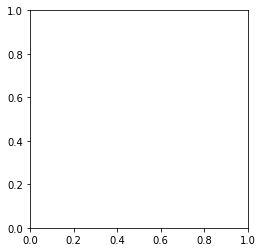

In [10]:
if __name__ == '__main__':
    pygmo_es()

In [20]:
from orbsim.constants import *
from orbsim.analyticals import *
from orbsim.simulators import *
derp = launch_sim([-2.09, -0.0001, 3.01])

0.0048051508844953175
smallest distance = 0.9942620847407281

symplectic runtime: 9.669917583465576


In [11]:
from mpl_toolkits.mplot3d import Axes3D


In [35]:
xa=[d[0] for d in derp[1]]
ya=[d[1] for d in derp[1]]
ha = [d[4] for d in derp[1]]


ValueError: too many values to unpack (expected 3)

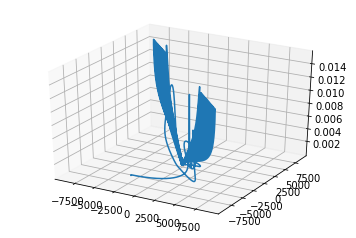

In [24]:
fig = plt.figure()
ax = fig.gca(projection="3d")

ax.plot(xa, ya, ha)

In [34]:
x,y,h

[[-3238.8578420433873, -5667.222681174772, 1e-06],
 [-3238.8533838643807, -5667.222682352816, 9.685751550210831e-06],
 [-3238.8102029041347, -5667.222693887533, 3.0143848398977057e-05],
 [-3238.6758144839487, -5667.222730429864, 5.3177583931389064e-05],
 [-3238.4387326089723, -5667.222794932303, 7.063030774962095e-05],
 [-3238.123835382847, -5667.222878039376, 8.139946537775949e-05],
 [-3237.7609178628004, -5667.222968255128, 8.738514647422495e-05],
 [-3237.3713053040183, -5667.223057312064, 9.054148216143147e-05],
 [-3236.967611565143, -5667.223140436957, 9.216269824255465e-05],
 [-3236.5566807174914, -5667.223215153625, 9.298478876441862e-05],
 [-3236.142075608863, -5667.223280246671, 9.339925014339645e-05],
 [-3235.725613668129, -5667.223335137182, 9.360786472285554e-05],
 [-3235.308212692299, -5667.223379554035, 9.371304922067317e-05],
 [-3234.8903338509303, -5667.223413371354, 9.376639391909484e-05],
 [-3234.472208292082, -5667.223436530725, 9.379378870962557e-05],
 [-3234.0539517

In [11]:
from math import cos, sin

c=[[cos(x/100.0*2*pi),sin(x/100.0*2*pi)] for x in range(100)]


[[1.0, 0.0],
 [0.9980267284282716, 0.06279051952931337],
 [0.9921147013144779, 0.12533323356430426],
 [0.9822872507286887, 0.1873813145857246],
 [0.9685831611286311, 0.2486898871648548],
 [0.9510565162951535, 0.3090169943749474],
 [0.9297764858882515, 0.3681245526846779],
 [0.9048270524660195, 0.4257792915650727],
 [0.8763066800438636, 0.4817536741017153],
 [0.8443279255020151, 0.5358267949789967],
 [0.8090169943749475, 0.5877852522924731],
 [0.7705132427757893, 0.6374239897486896],
 [0.7289686274214116, 0.6845471059286886],
 [0.6845471059286886, 0.7289686274214116],
 [0.6374239897486896, 0.7705132427757893],
 [0.5877852522924731, 0.8090169943749475],
 [0.5358267949789965, 0.8443279255020151],
 [0.48175367410171516, 0.8763066800438637],
 [0.42577929156507266, 0.9048270524660196],
 [0.3681245526846781, 0.9297764858882513],
 [0.30901699437494745, 0.9510565162951535],
 [0.24868988716485496, 0.9685831611286311],
 [0.18738131458572474, 0.9822872507286886],
 [0.12533323356430426, 0.992114701

In [12]:
range(0.0,1.0,0.01)

TypeError: 'float' object cannot be interpreted as an integer